## 3D Vertical Well Maker

### Michael Pyrcz, Associate Professor

#### University of Texas at Austin, Austin, TX 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

This workflow has been developed to build sets of synthetic vertical wells. 

* synthetic datasets are commonly needed for method and workflow testing

* this workflow is provided to support students, researchers 

#### Methodology

This workflow:

* uses GSLIB 3D simulation to build an exhaustive 3D model (regular grid)

* extracts columns of simulated values as the set of synthetic vertical well dataset

#### Getting Started

You will need Anaconda $\ge$ 3 installed to have access to:

* Jupyter

* Python $\ge$ 3

* Standard scientific computing packages such as numpy, pandas and scipy.

Here's the steps to get setup in Python with the GeostatsPy package:

1. Install Anaconda 3 on your machine (https://www.anaconda.com/download/). 
2. From Anaconda Navigator (within Anaconda3 group), go to the environment tab, click on base (root) green arrow and open a terminal. 
3. In the terminal type: pip install geostatspy.
4. Open Jupyter and in the top block get started by copy and pasting the code block below from this Jupyter Notebook to start using the geostatspy functionality.

#### Load the required libraries

The following code loads the required libraries from GeostatsPy:

In [1]:
import geostatspy.GSLIB as GSLIB                          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                    # GSLIB methods convert to Python  

We will also need some standard packages. These should have been installed with Anaconda $\ge$ 3.

In [2]:
import os                                                 # operating system, set current working directory 
import matplotlib.pyplot as plt                           # plotting
import numpy as np                                        # arrays and matrix math
from mpl_toolkits.mplot3d import Axes3D                   # 3D scatter plots
import pandas as pd                                       # DataFrames

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Set the Working Directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

* the GSLIB sgsim.exe file should be in this folder, the zipped set of executables are available [here](http://www.statios.com/software/gslib90.exe)

In [3]:
os.chdir("c:\PGE337")

#### The Simulation Grid

Let's set up the regular simulation grid.

* should cover the extent of the vertical wells

* wells will have the vertical resolution and extend from this grid.  The wells are columns from this model.

This grid sepcification is the GEO-DAS format.

* the grid is assumed to be orientated with the x-y-z coordinate system (no rotation)
* $nx$, $ny$ and $nz$ are the number of cells over each coordinate
* $x_{siz}$, $y_{siz}$ and $z_{siz}$ are the sizes of the cells over each coordinate
* xmn, ymn and zmn are the respective coordinates of the lower, left, cell centroid. e.g. $x_{mn} = x_{min} + x_{size} \times 0.5$ 


In [4]:
nx = 100; ny = 100; nz = 100
hsiz = 10.0; vsiz = 1.0; seed = 73073
xmin = 0.0; ymin = 0.0; zmin = 0.0
xmax = xmin + nx * hsiz; ymax = ymin + ny * hsiz; zmax = zmin + nz * vsiz
xmn = xmin + hsiz*0.5; ymn = ymin + hsiz*0.5; zmn = zmin + vsiz*0.5

#### Spatial Continuity Model

Next we specify the variogram model to impose spatial continuity.

* see standard geostatistics textbooks (Deutsch and Journel, 1998 or Pyrcz and Deutsch, 2014) for description of variogram parameterization

In [5]:
nst = 1; azi = 0.0; nug = 0.0; sill = 1                        # specify 3D variogram model parameters
hmax = 1000.0; hmin = 1000.0; hvert = 10.0                     # we are assuming 1 structure, another could be added
#hmax = 0.01; hmin = 0.01; hvert = 0.01                        # end case testing, test local distributions match global distribution

# Make variogram object for GeostatsPy
vario = geostats.make_variogram_3D(nug = 0.0,nst = nst,it1 = 1,cc1 = sill - nug,azi1 = azi,dip1 = 0.0,
    hmax1 = hmax,hmed1 = hmin,hmin1 = hvert)

#### Build a DUMMY Spatial Dataset

The DUMMY spatial dataset is:

* is outside the range of the spatial continuity of the model so it does not locally constrain the simulated values

* the feature 'Var' has the target distribution of the well data

Note, if the data is in correlation range of the model, it would cause singular matrices as all the x, y and z values are at the same location.

In [6]:
mean = 0.1; stdev = 0.02
vmin = mean - 4 * stdev; vmax = mean + 4 * stdev
null = np.zeros((200,4))
null.fill(-9999)
df = pd.DataFrame(null, columns = ['X', 'Y', 'Z','Var'])
df['Var'] = np.random.normal(loc = mean, scale = stdev, size = (200))
df.head()

,X,Y,Z,Var
0,-9999.0,-9999.0,-9999.0,0.114161
1,-9999.0,-9999.0,-9999.0,0.136641
2,-9999.0,-9999.0,-9999.0,0.120685
3,-9999.0,-9999.0,-9999.0,0.094468
4,-9999.0,-9999.0,-9999.0,0.113866


#### Simulation

Run the sequential Gaussian simulation to build a realization over the specified grid

* honors the target distribution 
* honors the vairogram model

The wrapper:

* creates a sgsim.par file in the working directory
* runs the sgsim executable with the parameter file
* reads the results back in as an numpy ndarray

In [7]:
sim = GSLIB.sgsim_3D(nreal=1, df=df, xcol='X', ycol='Y', zcol='Z', vcol='Var', nx=nx, ny=ny, nz=nz, 
                     hsiz=hsiz, vsiz=vsiz, seed=seed, var=vario, output_file="sgsim3d.out")
print('The ndarray is indexed ireal, iy, ix, iz with size ' + str(sim.shape) + '.')

The ndarray is indexed ireal, iy, ix, iz with size (1, 100, 100, 100).


#### Plotting the Model

Let's do a quite diagnostic plot of the model

* we plot regular plan view, horizontal layers from the model

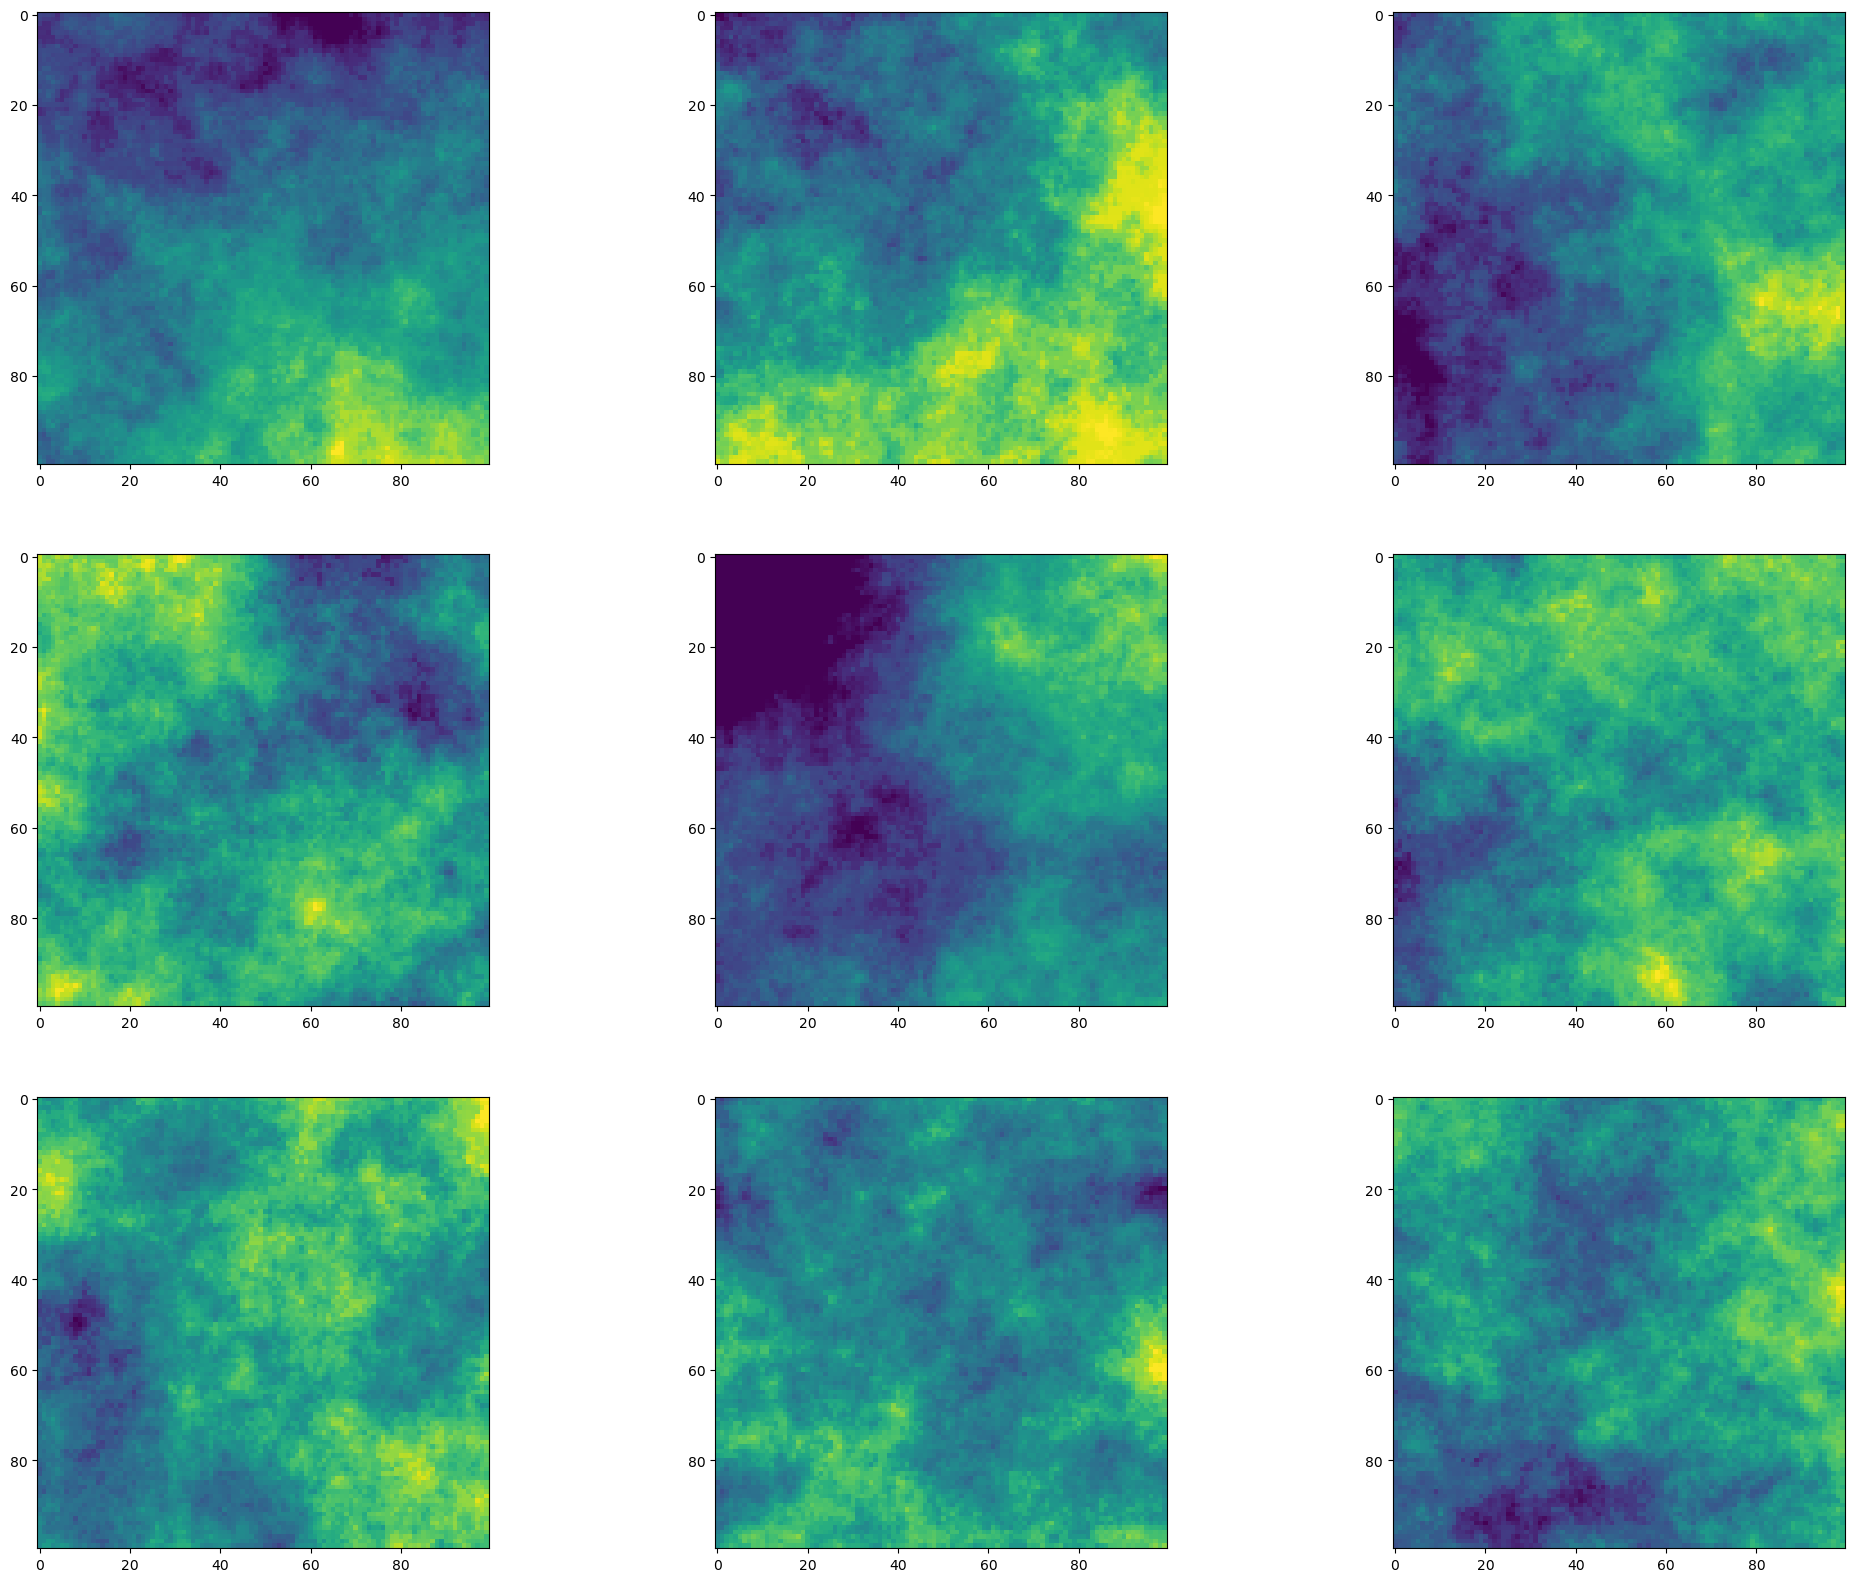

In [8]:
plt.subplot(3,3,1)
plt.imshow(sim[0,:,:,0])

plt.subplot(3,3,2)
plt.imshow(sim[0,:,:,10])

plt.subplot(3,3,3)
plt.imshow(sim[0,:,:,20])

plt.subplot(3,3,4)
plt.imshow(sim[0,:,:,30])

plt.subplot(3,3,5)
plt.imshow(sim[0,:,:,40])

plt.subplot(3,3,6)
plt.imshow(sim[0,:,:,50])

plt.subplot(3,3,7)
plt.imshow(sim[0,:,:,60])

plt.subplot(3,3,8)
plt.imshow(sim[0,:,:,70])

plt.subplot(3,3,9)
plt.imshow(sim[0,:,:,80])

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.2, wspace=0.2, hspace=0.2) # plot formatting
plt.show()

Now let's check some vertical sections.

* we do a 90 degree rotation since the imshow method assumes the first index is the y and the second is the x

* this is first quick checking, improved plotting could be used

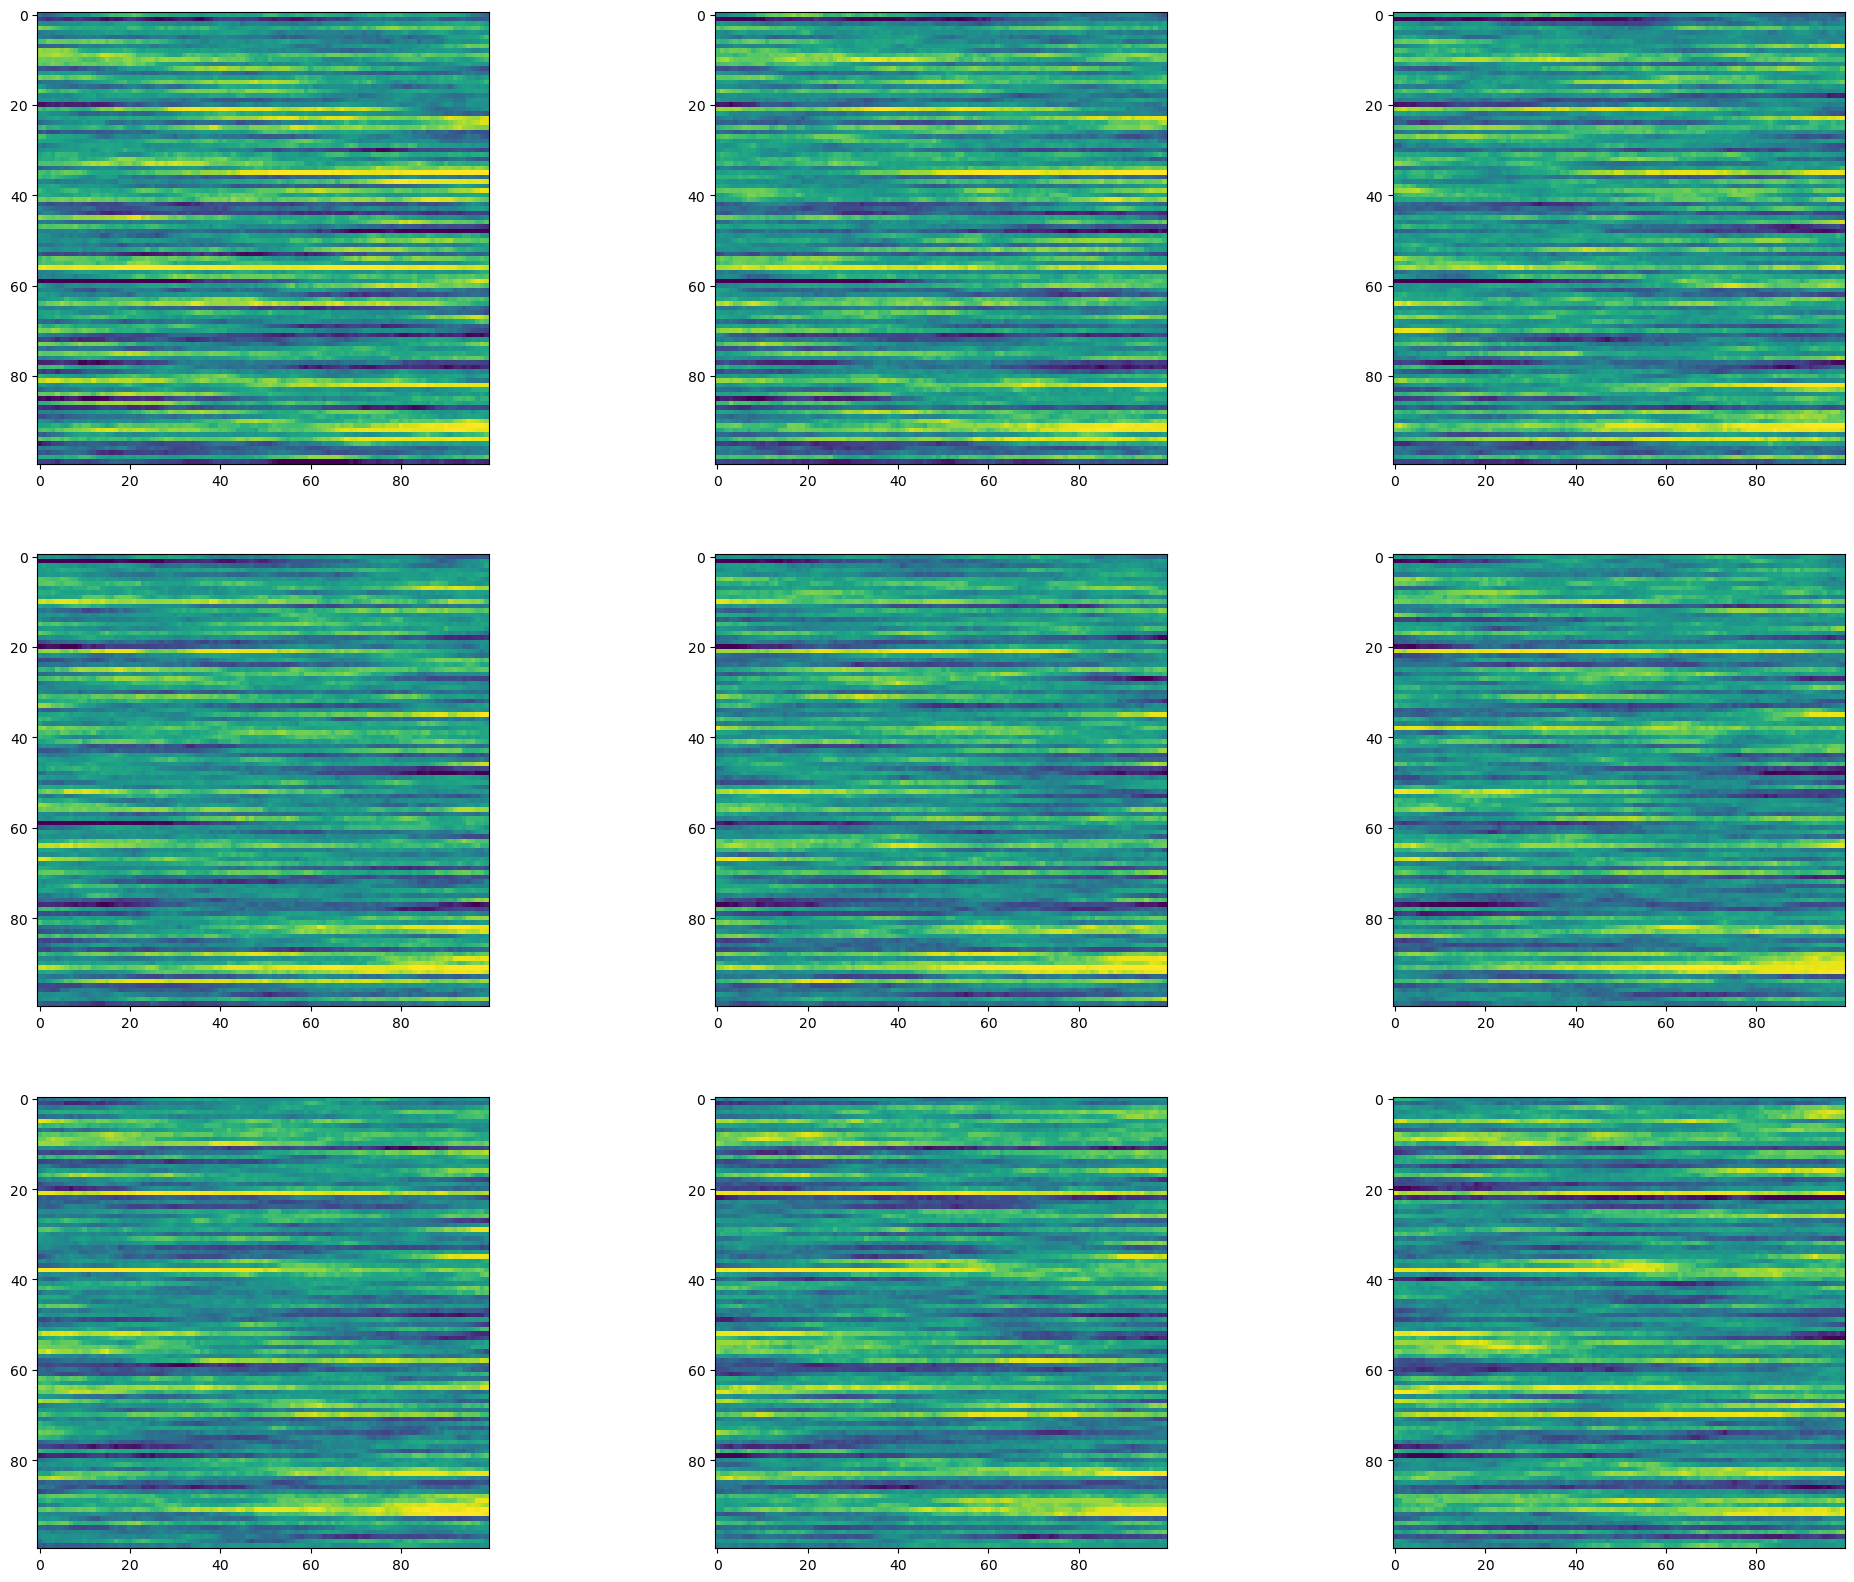

In [9]:
plt.subplot(3,3,1)
plt.imshow(np.rot90(sim[0,0,:,:]))

plt.subplot(3,3,2)
plt.imshow(np.rot90(sim[0,10,:,:]))

plt.subplot(3,3,3)
plt.imshow(np.rot90(sim[0,20,:,:]))

plt.subplot(3,3,4)
plt.imshow(np.rot90(sim[0,30,:,:]))

plt.subplot(3,3,5)
plt.imshow(np.rot90(sim[0,40,:,:]))

plt.subplot(3,3,6)
plt.imshow(np.rot90(sim[0,50,:,:]))

plt.subplot(3,3,7)
plt.imshow(np.rot90(sim[0,60,:,:]))

plt.subplot(3,3,8)
plt.imshow(np.rot90(sim[0,70,:,:]))

plt.subplot(3,3,9)
plt.imshow(np.rot90(sim[0,80,:,:]))

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.2, wspace=0.2, hspace=0.2) # plot formatting
plt.show()

#### Extract the Vertical Wells

Specify the well x and y locations below.

The subsequent code:

* loops over the wells 

* extracts the specific column of simulated values

In [10]:
wellx = [50, 200, 780, 550, 130, 820, 500]
welly = [560, 30, 710, 55, 620, 230, 500]

nwell = len(wellx)

xloc = np.zeros(nwell*nz); yloc = np.zeros(nwell*nz); zloc = np.zeros(nwell*nz);
wloc = np.zeros(nwell*nz); vloc = np.zeros(nwell*nz)

index = 0
for iwell in range(0,len(wellx)):
    wx = wellx[iwell]; wy = welly[iwell]
    ix = geostats.getindex(nx,xmn,hsiz,wx)
    iy = geostats.getindex(ny,ymn,hsiz,wy)
    for iz in range(0,nz):
        wz = vsiz*iz
        iz = geostats.getindex(nz,zmn,vsiz,wz)
        xloc[index] = wx; yloc[index] = wy; zloc[index] = wz
        vloc[index] = sim[0,iy,ix,iz]; wloc[index] = int(iwell)
        index = index + 1

#### Build the Synthetic Vertical Well DataFrame

Then we build a DataFrame with the vertical wells:

* Well - well index from 0 to n-1 wells
* X - x coordinate
* Y - y coordinate
* Z - z coordinate
* Var - simulated value

In [11]:
df_wells = pd.DataFrame({'Well':wloc,'X':xloc,'Y':yloc,'Z':zloc,'Var':vloc})
df_wells['Well'] = pd.to_numeric(df_wells['Well'], downcast='integer')
df_wells.head(n=10)

,Well,X,Y,Z,Var
0,0,50.0,560.0,0.0,0.0849
1,0,50.0,560.0,1.0,0.0849
2,0,50.0,560.0,2.0,0.0944
3,0,50.0,560.0,3.0,0.0901
4,0,50.0,560.0,4.0,0.0805
5,0,50.0,560.0,5.0,0.0639
6,0,50.0,560.0,6.0,0.1290
7,0,50.0,560.0,7.0,0.0935
8,0,50.0,560.0,8.0,0.0944
9,0,50.0,560.0,9.0,0.1142


#### Visualize the Synthetic Vertical Well DataFrame

Let's check the locations of the vertical wells with a 2D plan-view

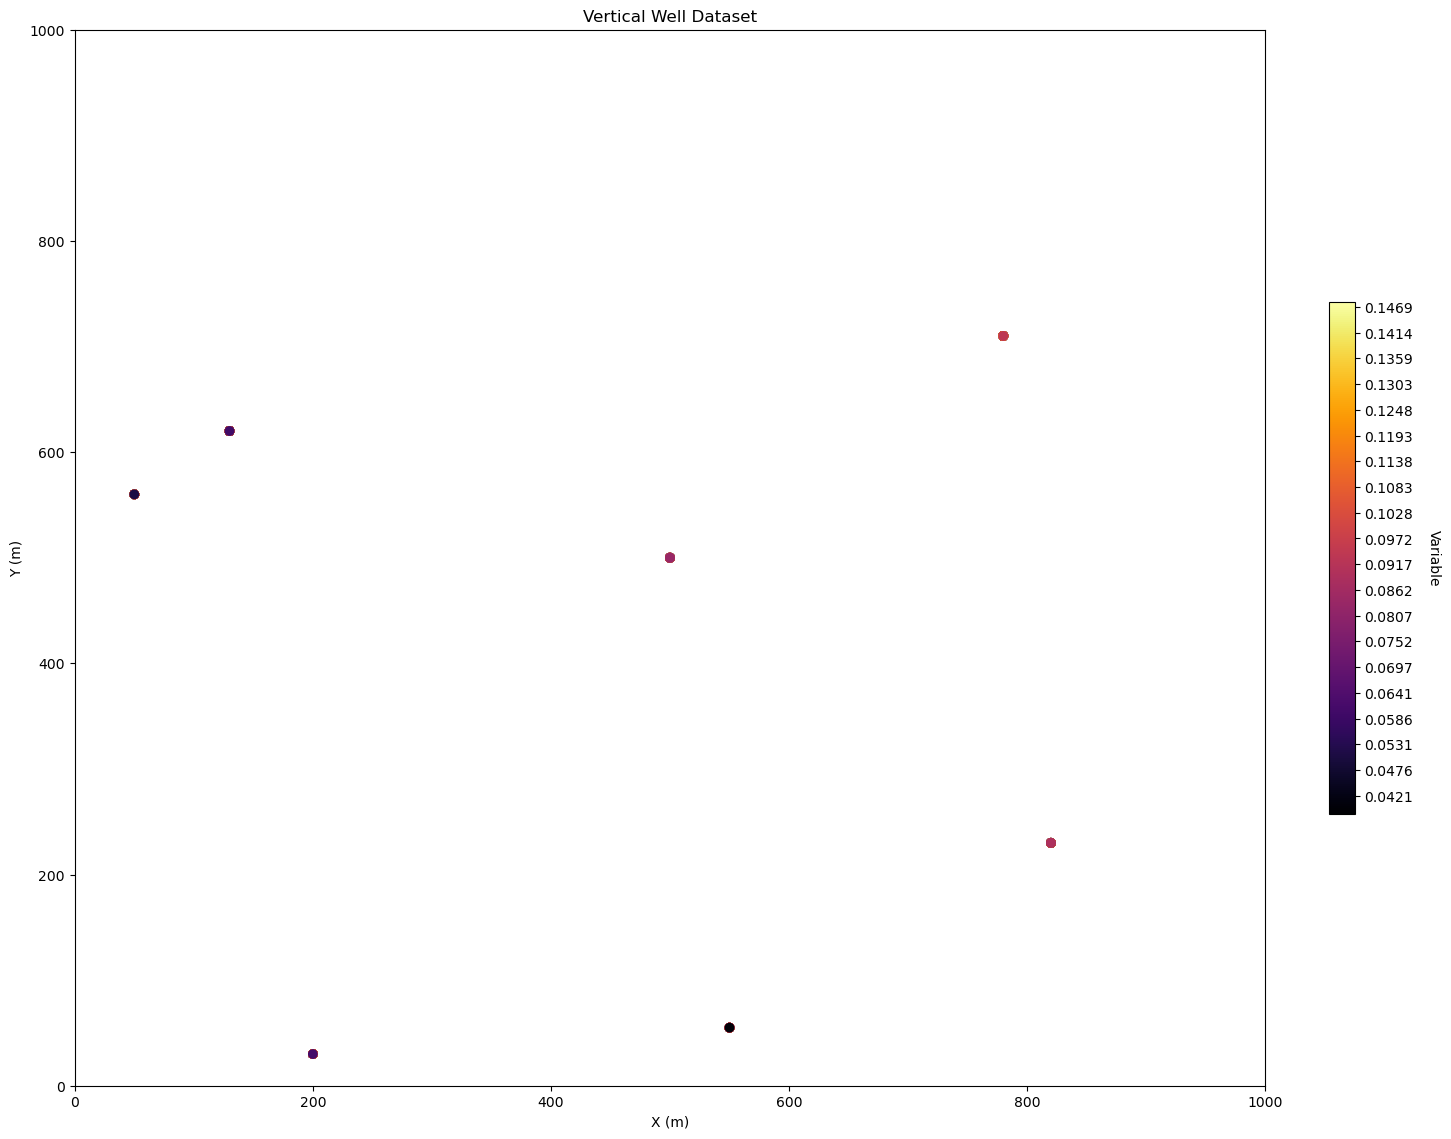

In [12]:
ax = plt.subplot(111)
p = ax.scatter(df_wells['X'].values, df_wells['Y'].values, c=df_wells['Var'].values, cmap='inferno');
ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)')
ax.set_xlim(xmin,xmax); ax.set_ylim(ymin,ymax)
ax.set_title('Vertical Well Dataset')
cbar = plt.colorbar(p, orientation="vertical", ticks=np.linspace(vmin,vmax,30),fraction=0.02)
cbar.set_label('Variable', rotation=270, labelpad=20)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.2, hspace=0.2) # plot formatting
plt.show()

Let's look at the well data in 3D.

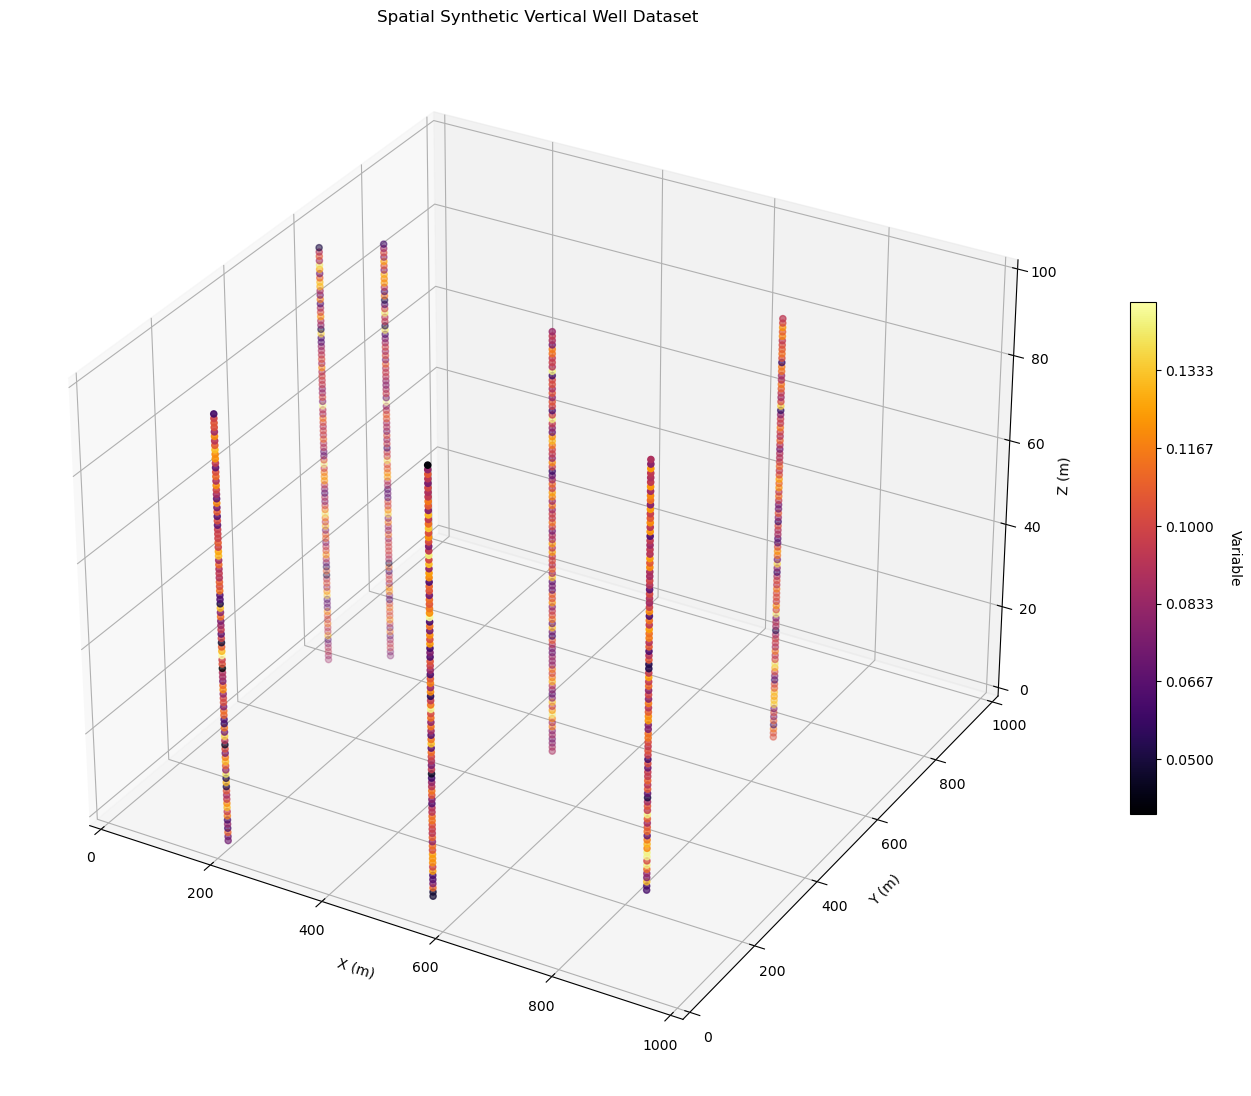

In [13]:
ax = plt.subplot(111, projection='3d')
p = ax.scatter(df_wells['X'].values, df_wells['Y'].values, df_wells['Z'].values, c=df_wells['Var'].values, cmap='inferno');
ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)'); ax.set_zlabel('Z (m)')
ax.set_xlim(0,1000); ax.set_ylim(0,1000); ax.set_zlim(0,100)
ax.set_title('Spatial Synthetic Vertical Well Dataset')
cbar = plt.colorbar(p, orientation="vertical", ticks=np.linspace(0.0,0.15,10),fraction=0.02)
cbar.set_label('Variable', rotation=270, labelpad=20)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.2, hspace=0.2) # plot formatting
plt.show()

#### Write out the Synthetic Vertical Wells

Write the synthetic vertical well DataFrame to a .csv file.

In [14]:
df_wells.to_csv('VerticalWells.csv')

#### Comments

This was a demonstration of spatial uncertainty modeling.  
  
I hope this was helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)
